In [1]:
import torch

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device ,torch.cuda.is_available())

cuda True


In [2]:
torch.cuda.is_available()

True

In [3]:
import sys,os, pickle

import torch.nn as nn
from transformers import BertModel, BertTokenizer
from transformers import BertForMaskedLM
from torch.utils.data import DataLoader, Dataset
from torch.utils.data import TensorDataset, random_split
from transformers import AdamW
from tqdm import tqdm  # for our progress bar

from sklearn.metrics import precision_recall_fscore_support , accuracy_score
import numpy as np
from transformers import AutoModelForSequenceClassification

import random


EXPERIMENT_NAME="TYPE_WRITER_40_class_scaled"

BATCH_SIZE = 5
MAX_TOKEN_SIZE = 512


In [4]:
TYPE_MAPPING ={'int': 0, '*structure': 1, 'array_char': 2, '*char': 3, '*int': 4, 
               'array_int': 5, 'char': 6, 'double': 7, '**char': 8, 'unsigned int': 9,
                 'long int': 10, 'float': 11, 'long unsigned int': 12, 'structure': 13, 
                 'const': 14, '*const': 15, 'long long unsigned int': 16, '*enumeration': 17,
                   'unsigned char': 18, 'long long int': 19, '*unsigned char': 20, 
                   '*float': 21, '**int': 22, '*double': 23, '**structure': 24, '*union': 25, 
                   'short unsigned int': 26, 'enumeration': 27, '*array_int': 28, 
                   'array_double': 29, '*array_float': 30, 'array_structure': 31, 
                   'array_*char': 32, 'short int': 33, 'array_float': 34, '*unsigned int': 35, 
                   'union': 36, '*array_char': 37, '*array_const': 38, 
                   'array_unsigned char': 39, 'signed char': 40, 'array_long int': 41}

    

In [5]:
DATA_PATH = '/hdd0/nahid/instructions_and_type_data_10k'
MODEL_SAVE_PATH =  '/hdd0/nahid/models'
TYPE_COUNT ={}
FINAL_TYPE_COUNT = {}
TYPE_PROBABILITY = {}

for key in TYPE_MAPPING.keys():
    TYPE_COUNT[key] = 0
    FINAL_TYPE_COUNT[key] = 0
    
MAX_TYPE_SAMPLE  =10000
ALL_INPUT_LIST = []
ALL_INPUT_SLICE_INFO  = []
ALL_LABEL_LIST = []
#TODO dont load all at a time in memry
def make_dataset():

    #count how many real samples
    for fi,pkl_file_name in enumerate(os.listdir(DATA_PATH)):
        pkl_path = os.path.join(DATA_PATH,pkl_file_name)
        with open(pkl_path, 'rb') as file:
            model_input_list, model_label_list = pickle.load(file)

            for i in range(len(model_input_list)):

                type_str = model_label_list[i]

                TYPE_COUNT[type_str] +=1
    
    print(TYPE_COUNT)
    #make the probability
    for key in TYPE_COUNT.keys():
        print(MAX_TYPE_SAMPLE , TYPE_COUNT[key] ,key)
        TYPE_PROBABILITY[key] = MAX_TYPE_SAMPLE/TYPE_COUNT[key]
    
    print(TYPE_PROBABILITY)
    #fill dataset with that probability
    for fi,pkl_file_name in enumerate(os.listdir(DATA_PATH)):
        pkl_path = os.path.join(DATA_PATH,pkl_file_name)

        with open(pkl_path, 'rb') as file:
            model_input_list, model_label_list = pickle.load(file)

            for i in range(len(model_input_list)):

                type_str = model_label_list[i]
                type_label = TYPE_MAPPING[type_str]
                backward_slice , target_slice, forward_slice = model_input_list[i]

                if random.random()<=TYPE_PROBABILITY[type_str]:

                    ALL_INPUT_LIST.append(backward_slice + target_slice + forward_slice)
                    ALL_INPUT_SLICE_INFO.append([len(backward_slice) , len(target_slice) , len(forward_slice)])
                    ALL_LABEL_LIST.append(type_label)
                    
                    FINAL_TYPE_COUNT[type_str]+=1
make_dataset()

{'int': 1613834, '*structure': 338137, 'array_char': 66404, '*char': 146834, '*int': 153363, 'array_int': 55944, 'char': 53342, 'double': 28414, '**char': 24789, 'unsigned int': 42039, 'long int': 27861, 'float': 31568, 'long unsigned int': 18137, 'structure': 31933, 'const': 11989, '*const': 22016, 'long long unsigned int': 6438, '*enumeration': 328, 'unsigned char': 10085, 'long long int': 17829, '*unsigned char': 8356, '*float': 3265, '**int': 10346, '*double': 3921, '**structure': 25425, '*union': 1180, 'short unsigned int': 4236, 'enumeration': 3332, '*array_int': 7808, 'array_double': 2173, '*array_float': 1259, 'array_structure': 3882, 'array_*char': 2165, 'short int': 3451, 'array_float': 1584, '*unsigned int': 2828, 'union': 1458, '*array_char': 1952, '*array_const': 104, 'array_unsigned char': 1355, 'signed char': 1283, 'array_long int': 1629}
10000 1613834 int
10000 338137 *structure
10000 66404 array_char
10000 146834 *char
10000 153363 *int
10000 55944 array_int
10000 5334

In [6]:
print(TYPE_COUNT)

print(TYPE_PROBABILITY)
print(FINAL_TYPE_COUNT)

{'int': 1613834, '*structure': 338137, 'array_char': 66404, '*char': 146834, '*int': 153363, 'array_int': 55944, 'char': 53342, 'double': 28414, '**char': 24789, 'unsigned int': 42039, 'long int': 27861, 'float': 31568, 'long unsigned int': 18137, 'structure': 31933, 'const': 11989, '*const': 22016, 'long long unsigned int': 6438, '*enumeration': 328, 'unsigned char': 10085, 'long long int': 17829, '*unsigned char': 8356, '*float': 3265, '**int': 10346, '*double': 3921, '**structure': 25425, '*union': 1180, 'short unsigned int': 4236, 'enumeration': 3332, '*array_int': 7808, 'array_double': 2173, '*array_float': 1259, 'array_structure': 3882, 'array_*char': 2165, 'short int': 3451, 'array_float': 1584, '*unsigned int': 2828, 'union': 1458, '*array_char': 1952, '*array_const': 104, 'array_unsigned char': 1355, 'signed char': 1283, 'array_long int': 1629}
{'int': 0.0061964241675413955, '*structure': 0.029573811798176478, 'array_char': 0.1505933377507379, '*char': 0.06810411757494858, '*i

In [7]:
print(len(ALL_INPUT_LIST))

264126


In [8]:
tokenizer  = BertTokenizer.from_pretrained("./multytask-tokenizer")

#https://github.com/huggingface/tokenizers/issues/247

mask_token_id, look_token_id, eoi_token_id = tokenizer.encode('[MASK] [LOOK] [EOI]')[1:-1]

print(mask_token_id, look_token_id, eoi_token_id)

4 6 5


In [9]:

VOCAB_SIZE = tokenizer.vocab_size

print('VOCAB SIZE : ', (tokenizer.vocab_size))

VOCAB SIZE :  17697


In [10]:
# Create model instance
#TODO*** USE PRETRAINED
model = AutoModelForSequenceClassification.from_pretrained("bert-base-cased", num_labels=len(TYPE_MAPPING.items()))
model.to(device)




Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [11]:

# Tokenize input text
# inputs = tokenizer(input_text, padding=True, truncation=True, return_tensors='pt')
# inputs = tokenizer(ALL_INPUT_LIST, max_length= MAX_TOKEN_SIZE,padding='max_length', truncation=True , return_tensors='pt')
# print(inputs.keys())

# labels = ALL_LABEL_LIST.to(device)

In [12]:
# print(inputs.keys())
# print(inputs.token_type_ids)
# inputs.token_type_ids[0][0] =1
# print(inputs.token_type_ids)
# #TODO set token type ids

In [13]:
# class BinaryDataset(torch.utils.data.Dataset):
#     def __init__(self, encodings):
#         self.encodings = encodings
#     def __getitem__(self, idx):
#         return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
#     def __len__(self):
#         return len(self.encodings.input_ids)

In [14]:
class BinaryDataset(torch.utils.data.Dataset):
    def __init__(self, texts, labels, tokenizer):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        
    def __getitem__(self, index):
        text = self.texts[index]
        label = self.labels[index]
        
        # Tokenize the text
        tokenized_text = (self.tokenizer(text , max_length= MAX_TOKEN_SIZE,padding='max_length', truncation=True , return_tensors='pt')).to(device)
        
        # Convert tokens to input IDs
#         input_ids = self.tokenizer.convert_tokens_to_ids(tokenized_text)
        
        # Create input tensors
#         input_ids = tokenized_text['input_ids']  #torch.tensor(input_ids)
        label = torch.tensor([label]).to(device)
        
        return tokenized_text, label
        
#         return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
    def __len__(self):
        return len(self.texts)

In [15]:
print(len(ALL_INPUT_LIST ), len(ALL_LABEL_LIST))

264126 264126


In [16]:
dataset = BinaryDataset(ALL_INPUT_LIST, ALL_LABEL_LIST,tokenizer)
train_size = int(0.8 * len(dataset))
validation_size = len(dataset) - train_size

train_dataset, validation_dataset = torch.utils.data.random_split(dataset, [train_size, validation_size])
train_loader      = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [17]:
# global_task2_metrices, global_task1_metrices ,v_global_task1_metrices, v_global_task2_metrices

from numpy import *
import math
import matplotlib.pyplot as plt


def plot_graph(task1_metrices,   v_task1_metrices, label = "TypeGraph" ):
    
    plt.ioff()

    font_size = 10
    x_labels = [ i for i in range(len(task1_metrices)) ]
    
    task1_f1 = [ i['f1'] for i in task1_metrices ]

    
    v_task1_f1 = [ i['f1'] for i in v_task1_metrices ]

    

    plt.ylabel(' F1 ',fontsize=font_size)
    plt.plot(x_labels, task1_f1 , 'r') 

    
    plt.plot(x_labels, v_task1_f1 , 'r' , linestyle = '--') 

    
    plt.xlabel("Epoch", fontsize=font_size)
    plt.title(label,fontsize=font_size)
    plt.legend([' Type Train',  'Type Val' ], loc='upper left')
    
    plt.savefig('./output/'+label+'_f1.pdf')
    plt.close()
    plt.show()
    
    ################################
    ################# LOSS #########
    ################################
    
    task1_loss = [ i['loss'] for i in task1_metrices ]

    
    v_task1_loss = [ i['loss'] for i in v_task1_metrices ]
    

    plt.ylabel(' LOSS ',fontsize=font_size)
    plt.plot(x_labels, task1_loss , 'r') 
    
    plt.plot(x_labels, v_task1_loss , 'r' , linestyle = '--') 

    
    plt.xlabel("Epoch", fontsize=font_size)
    plt.title(label,fontsize=font_size)
    plt.legend([' Type Train',  'Type Val'], loc='upper left')
    
    plt.savefig('./output/'+label+'_loss.pdf')
    plt.close()
    plt.show()
    
    

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import multilabel_confusion_matrix,ConfusionMatrixDisplay
import seaborn as sns

def plot_confusion_matrix(true_labels, predicted_labels, label='confusion_matrix'):

    class_labels = list(TYPE_MAPPING.keys())  
    class_labels = [c for c in class_labels]

    cm = confusion_matrix(true_labels, predicted_labels ) 
    
    fig, ax = plt.subplots(figsize=(20, 20))
    
    res = sns.heatmap(cm,
            annot=True , cmap="Blues" , fmt='g' , xticklabels=class_labels,linewidths = .01,
                      yticklabels=class_labels,linecolor="Gray")
    for _, spine in res.spines.items():
        spine.set_visible(True)
        spine.set_linewidth(1)
    
    plt.ylabel('Actual',fontsize=13)
    plt.xlabel('Prediction',fontsize=13)
    plt.title('Confusion Matrix',fontsize=17)
    plt.savefig('./output/'+label+'_conf.pdf',dpi=200)
    plt.show()
    plt.close()
# plot_confusion_matrix(v_ground_truth_s , v_prediction_s ,label=EXPERIMENT_NAME)

In [19]:


# initialize optimizer
optim = AdamW( model.parameters() , lr=5e-6)
criterion = nn.CrossEntropyLoss()

/home/tools/anaconda3/envs/light/lib/python3.8/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [20]:
def training_loop(model ,data_loop, is_training = False):
    
    prediction_s, ground_truth_s = [], []
    losses = []

    for N,batch in enumerate(data_loop):
        
        
        # Forward pass
        if is_training == True:
            optim.zero_grad()
        
        batch_input, batch_labels = batch
        if len(batch_labels)<BATCH_SIZE:
            continue
        batch_input_ids= batch_input['input_ids']
        batch_attention_mask=batch_input['attention_mask']
        batch_token_type_ids =batch_input['token_type_ids']

        outputs = model(input_ids=batch_input_ids.squeeze(),
                        attention_mask=batch_attention_mask.squeeze(),
                        token_type_ids=batch_token_type_ids.squeeze(),
                        labels=batch_labels )
        
#

        loss = outputs.loss
        losses.append(loss.item())
        
        logits = outputs.logits
        predictions = torch.argmax(logits, dim=1)
        


        prediction_s.extend(predictions.detach().cpu().numpy().flatten())
        ground_truth_s.extend(batch_labels.detach().cpu().numpy().flatten())


        if is_training == True:
            loss.backward()
            optim.step()


        # print relevant info to progress bar
        data_loop.set_description(f'Epoch {ecpoch}')
        data_loop.set_postfix(loss=loss.item())

    ###### Training Scores
    accuracy = accuracy_score(ground_truth_s, prediction_s)    
    precision, recall, f1, _ = precision_recall_fscore_support(ground_truth_s,prediction_s,average='weighted')
    metrices = {'accuracy':accuracy ,
                      'precision':precision, 
                      'recall':recall, 
                      'f1':f1,
                      'loss': (sum(losses) / len(losses))}
    


    return metrices , prediction_s, ground_truth_s
    

Epoch 
/home/tools/anaconda3/envs/light/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training metrices:  {'accuracy': 0.44066729768102225, 'precision': 0.4391385724639059, 'recall': 0.44066729768102225, 'f1': 0.42572717169142954, 'loss': 2.0515700382104263}


Epoch 
/home/tools/anaconda3/envs/light/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


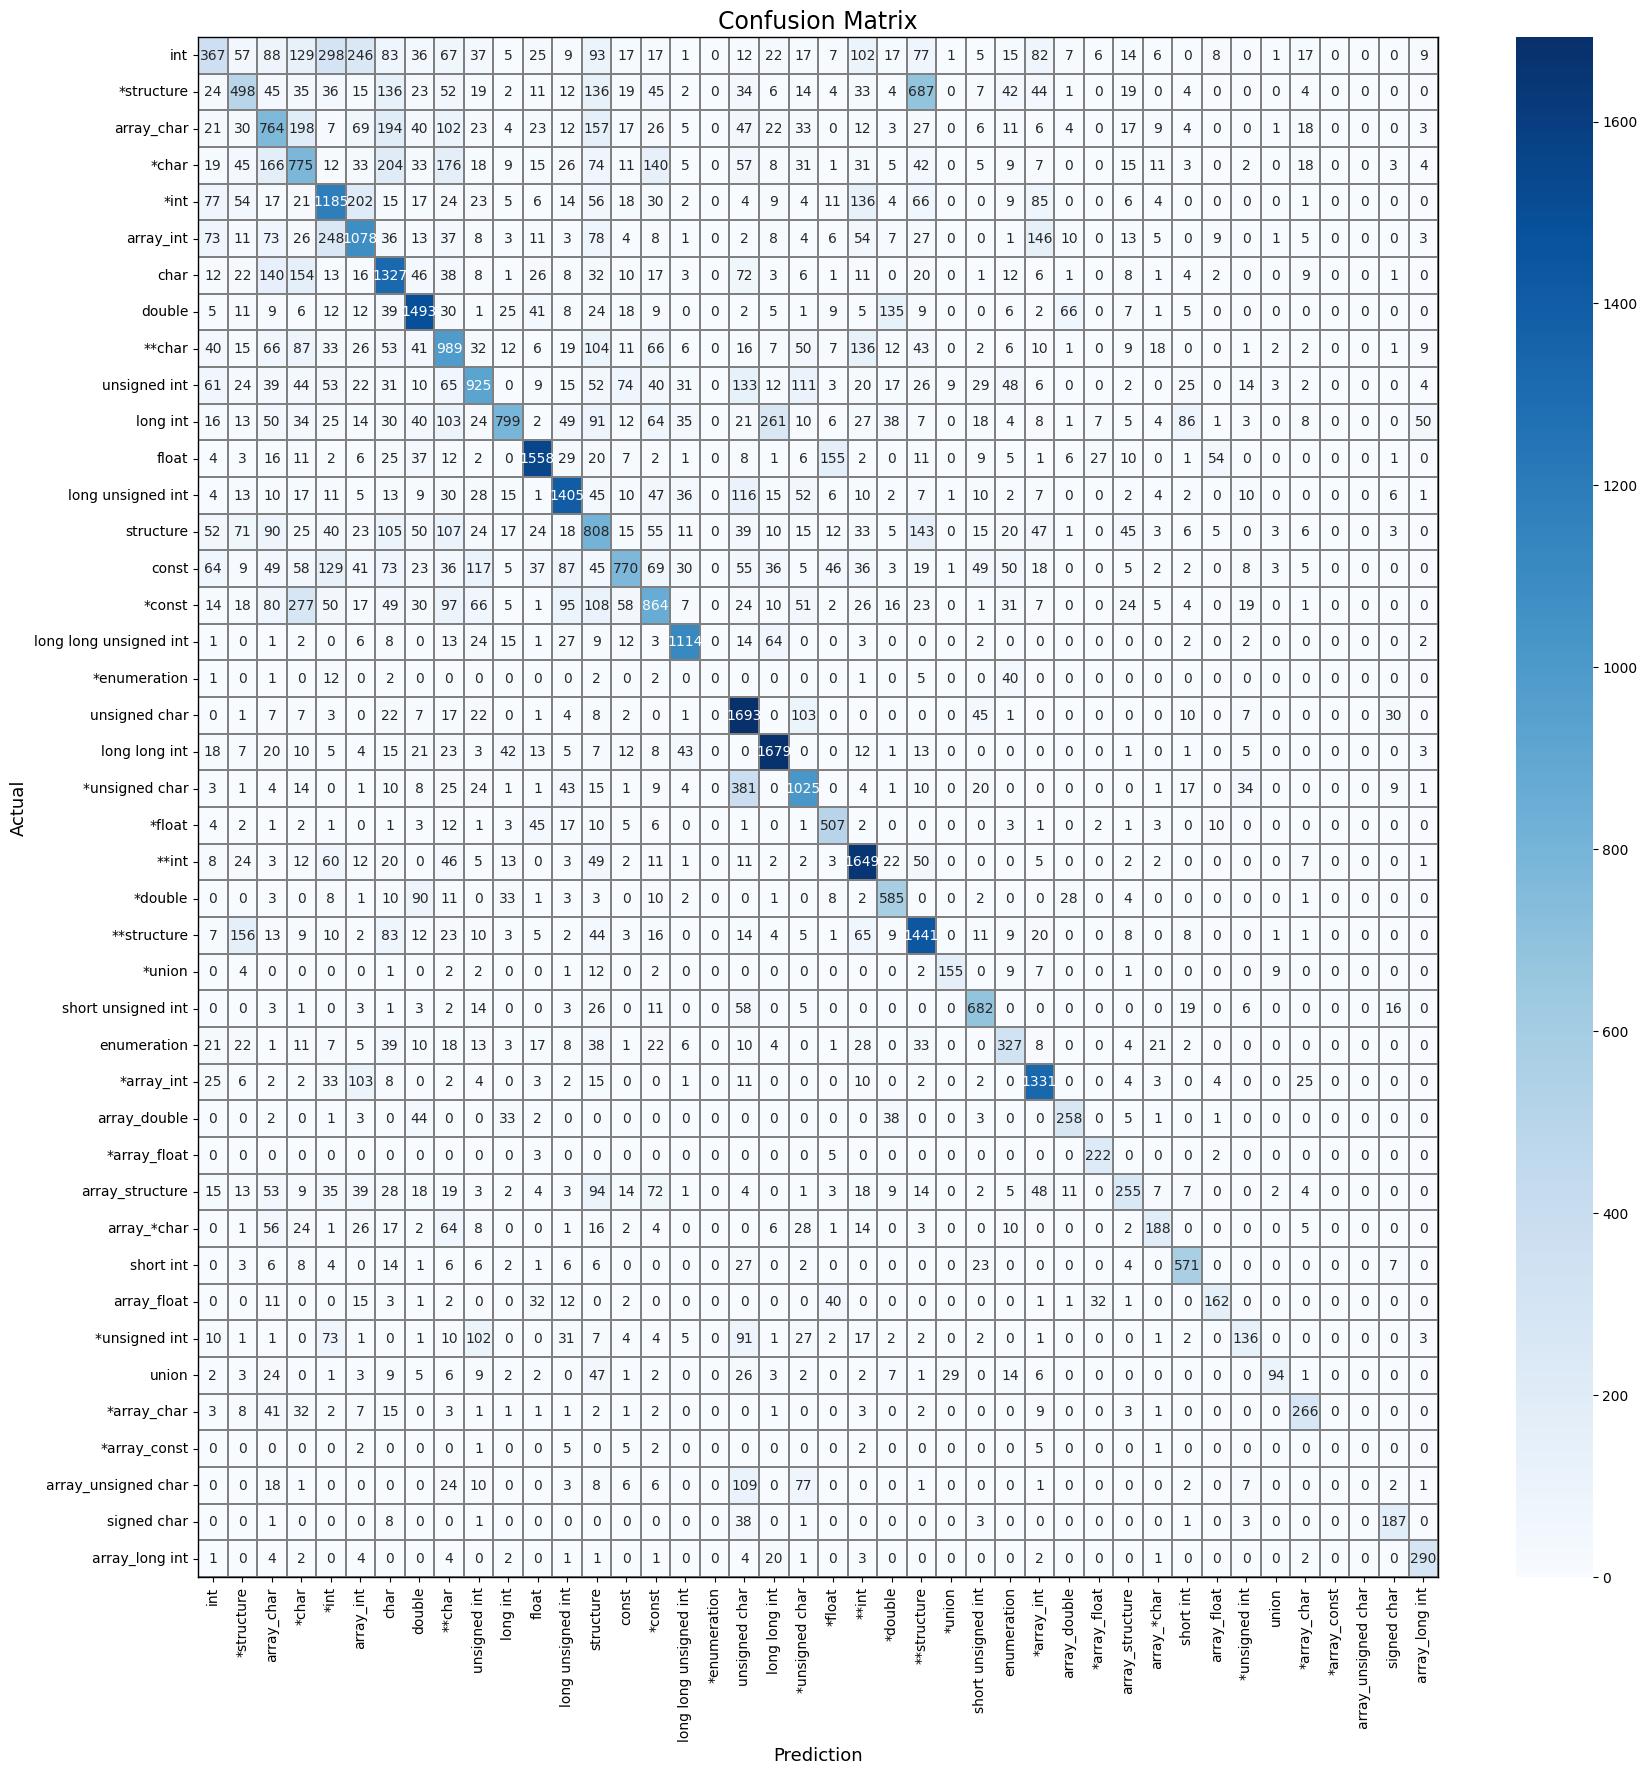

v_metrices:  {'accuracy': 0.5759015617605301, 'precision': 0.5730861268798043, 'recall': 0.5759015617605301, 'f1': 0.5629330549486184, 'loss': 1.5286396324920164}


Epoch 

In [ ]:
EPOCHS = 100


global_metrices = []
v_global_metrices = []


for ecpoch in range(EPOCHS):
    
    train_loop = tqdm(train_loader, leave=True)
    model.train()
    metrices,prediction_s, ground_truth_s  = training_loop(model ,train_loop, is_training = True)
    print('Training metrices: ',metrices)
    global_metrices.append(metrices)
    
    with torch.no_grad():
        model.eval()
        validation_loop = tqdm(validation_loader, leave=True)
        v_metrices, v_prediction_s, v_ground_truth_s  = training_loop(model ,validation_loop, is_training = False)
        plot_confusion_matrix(v_ground_truth_s , v_prediction_s ,label=EXPERIMENT_NAME)
        print('v_metrices: ',v_metrices)
        v_global_metrices.append(v_metrices)
    plot_graph(global_metrices,v_global_metrices , label = EXPERIMENT_NAME)
#     break
    model.save_pretrained(MODEL_SAVE_PATH +EXPERIMENT_NAME)


In [ ]:
model.save_pretrained(MODEL_SAVE_PATH +EXPERIMENT_NAME)